# Visualization reducing grammar

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.patches as mpatches
import os
import string
import scipy.optimize as opt
import matplotlib.colors as mcolors
import random
from nltk import PCFG as nltk_PCFG

## Inspecting the corpora

DONE  
1. Sentence length
2. Vocabsize
3. Amount of terminals
4. Amount of non terminals
5. Distribution (Zipf)
6. Train/test/dev  
- - - - - 
STILL TO DO  
1. Heap's law

#### Per top k

In [2]:
# open txt file
VERSION = 'normal'
TOP_K = '0.2'
with open(f'corpora/results/train_sent_normal_{TOP_K}.txt', 'r') as file:
    data = [item.strip('\n').split(' ') for item in file.readlines()]
    
lengths_data = [len(item) for item in data]

In [3]:
# load grammar file
with open(f'grammars/nltk/{VERSION}/subset_pcfg_{TOP_K}.txt') as f:
    raw_grammar = f.read()
grammar = nltk_PCFG.fromstring(raw_grammar)

In [4]:
def stats_dataset(dataset, top_k) -> None:
    print(
    f"""The length of the corpus is {len(dataset)} with top {top_k} of the prob mass.
    The maximum length is {max(dataset)}. 
    The minimum length is {min(dataset)}.""")

In [8]:
def plot_length_dist(dataset, name) -> None:
    # plot smooth distribution of sentence lengths
    # density = gaussian_kde(dataset)
    x = np.linspace(min(dataset), max(dataset), len(dataset))

    plt.hist(dataset, bins=10, alpha=0.7, label='PTB')
    # plt.plot(x, density(x), color='#FF7F0E')
    # plt.fill_between(x, density(x), alpha=0.5, color='#FF7F0E')
    plt.xlabel('Sentence length')
    plt.title(f'Distribution of sentence lengths of {name}')

In [9]:
stats_dataset(lengths_data, TOP_K)

The length of the corpus is 800000 with top 0.2 of the prob mass.
    The maximum length is 21. 
    The minimum length is 7.


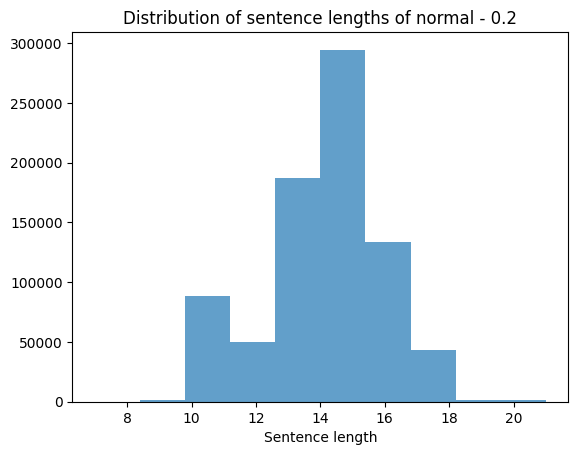

In [10]:
plot_length_dist(lengths_data, f'normal - {TOP_K}')

#### Compare different top k's

In [29]:
VERSION = 'normal'
TOPKS = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

all_data = []
all_lengths = []
for top_k in TOPKS:
    with open(f'corpora/results/train_sent_normal_{top_k}.txt', 'r') as file:
        data = [item.strip('\n').split(' ') for item in file.readlines()]
        all_data.append(data)
        all_lengths.append([len(item) for item in data])

In [13]:
def create_lookup_probs(pcfg):
    """
    Create probability lookup table
    """
    pcfg._lhs_prob_index = {}
    for lhs in pcfg._lhs_index.keys():
        lhs_probs = [prod.prob() for prod in pcfg.productions(lhs=lhs)]
        pcfg._lhs_prob_index[lhs] = lhs_probs
    
    return pcfg

In [14]:
# load grammar file
all_grammars = []
for top_k in TOPKS:
    with open(f'grammars/nltk/{VERSION}/subset_pcfg_{top_k}.txt') as f:
        raw_grammar = f.read()
    grammar = nltk_PCFG.fromstring(raw_grammar)

    grammar = create_lookup_probs(grammar)
    productions = [rule for lhs in grammar._lhs_index.values() for rule in lhs]
    all_grammars.append(productions)

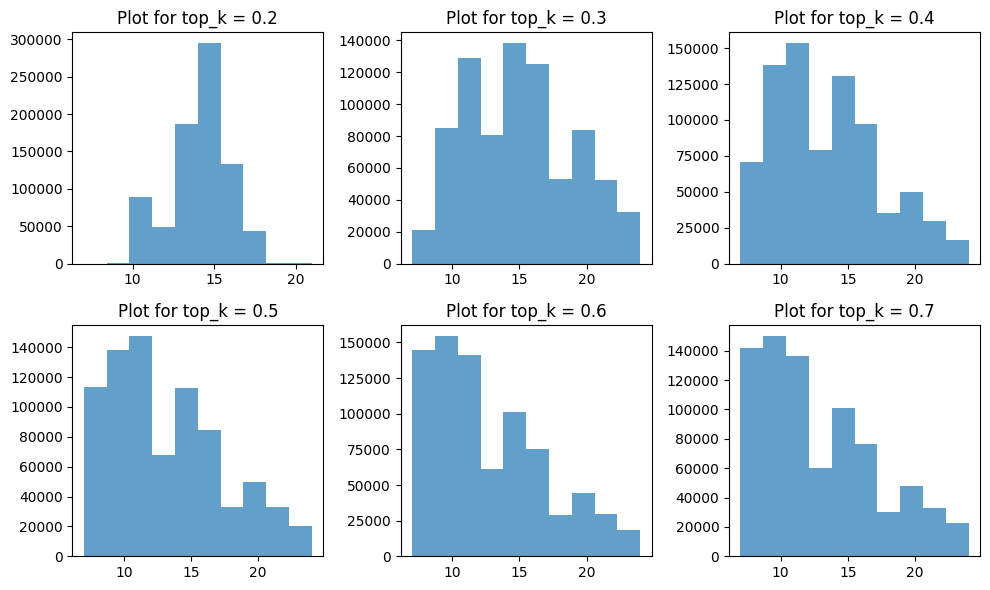

In [31]:
# Example function to plot for a specific top_k value, using ax object
def plot_for_top_k(ax, top_k, data):
    x = np.linspace(min(data), max(data), len(data))

    ax.hist(data, bins=10, alpha=0.7, label='PTB')
    # Your actual plotting code goes here
    ax.set_title(f"Plot for top_k = {round(top_k, 1)}")

# Values of top_k to plot
top_k_values = np.arange(0.2, 0.9, 0.1)  # From 0.2 to 0.8, inclusive, with a step of 0.1

# Setup subplot grid - change nrows, ncols based on your needs
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 6))  # Adjust figure size as needed

# Flatten the axes array if necessary
axes = axes.flatten()

# Create a subplot for each top_k value
for ax, top_k, lengths in zip(axes, top_k_values, all_lengths):
    plot_for_top_k(ax, top_k, lengths)

# If you have any unused subplots, you can turn them off
for i in range(len(top_k_values), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()

In [18]:
def plot_vocab_size(all_data):
    vocab_sizes = [len(set([word for sent in item for word in sent])) for item in all_data]
    print(vocab_sizes)
    plt.bar(['0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8'], vocab_sizes, color='#FF7F0E')

    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)
    ax.get_yaxis().set_visible(True) 

    plt.xlabel('Top k')
    plt.ylabel('Vocabulary size')
    plt.title('Vocabulary size of corpora with increasing probability mass')

[232, 617, 1974, 3479, 6728, 11542, 16390]


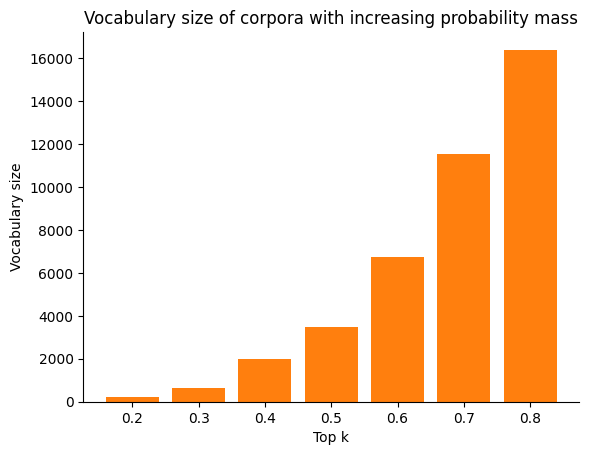

In [19]:
plot_vocab_size(all_data)

In [22]:
# plot amount of non terminals per corpus
def plot_non_terminals(all_data):
    non_terminals = []
    for item in all_data:
        non_terminals.append(len(set([prod.lhs() for prod in item])))
    print(non_terminals)
    plt.bar(['0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8'], non_terminals, color='#FF7F0E')

    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)
    ax.get_yaxis().set_visible(True) 

    plt.xlabel('Top k')
    plt.ylabel('Amount of non-terminals')
    plt.title('Amount of non-terminals in corpora with increasing probability mass')

[114, 157, 299, 420, 513, 660, 699]


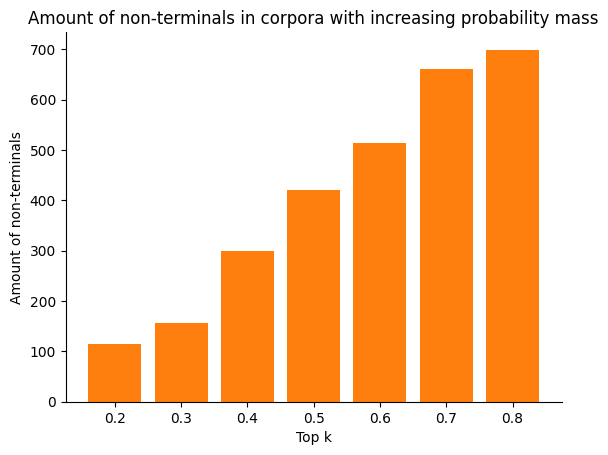

In [23]:
plot_non_terminals(all_grammars)

In [26]:
# plot amount of non terminals per corpus
def plot_terminals(all_data):
    non_terminals = []
    for item in all_data:
        non_terminals.append(len(set([prod.rhs() for prod in item if type(prod.rhs()[0]) == str])))
    print(non_terminals)
    plt.bar(['0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8'], non_terminals, color='#FF7F0E')

    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)
    ax.get_yaxis().set_visible(True) 

    plt.xlabel('Top k')
    plt.ylabel('Amount of terminals')
    plt.title('Amount of terminals in corpora with increasing probability mass')

[233, 617, 1974, 4587, 7551, 12079, 17549]


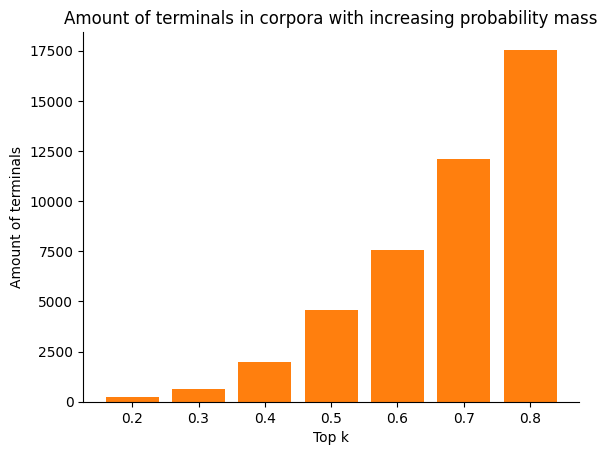

In [27]:
plot_terminals(all_grammars)

In [32]:
def create_vocab(data):
    unwantedCharacters = list(string.punctuation)

    vocab = defaultdict(int)
    # Cleaning and counting the Text
    for text in data:
        for word in text:
            # Remove unwanted characters from the texts
            if word in unwantedCharacters:
                text.remove(word)
                continue

            vocab[word] += 1

    return vocab


def zipf_equation(x, alpha, beta):
    return 1/(x+beta)**alpha


def Zipf_curve(data):
    vocab = create_vocab(data)

    freq = np.zeros(len(vocab.keys()))
    rank = np.zeros(len(vocab.keys()))
    for i, count in enumerate(vocab.values()):
        sample = np.random.binomial(count, 0.5)
        freq[i] = sample
        rank[i] = count - sample
    
    indices = np.argsort(rank)[::-1]
    rank = np.sort(rank[::-1])
    freq = freq[indices]
    freq = freq / np.linalg.norm(freq)
    x_values = np.arange(1, len(vocab.keys())+1)

    # Fit Eq. 2 to the data
    params, _ = opt.curve_fit(zipf_equation, x_values, freq, maxfev=10000)

    # Generate fitted line
    fitted_line = zipf_equation(x_values, *params)

    return x_values, freq, fitted_line, params


def plot_Zipf_curve(data):
    plt.figure(figsize=(4, 4))
    colors = ["blue", "lightgreen"]
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)

    x_values, y_values, fitted_line, _ = Zipf_curve(data)

    # plot the data and the fitted line
    plt.hexbin(np.log(x_values), np.log(y_values), gridsize=70, cmap=cmap, bins='log')
    plt.plot(np.log(x_values), np.log(fitted_line), color='red')

/var/folders/4j/29pdgy4j4cx8q11l89q0hpch0000gn/T/ipykernel_26437/2114120486.py:14: RuntimeWarning: divide by zero encountered in log
  hb = ax.hexbin(np.log(x_values), np.log(y_values), gridsize=70, cmap=cmap, bins='log')


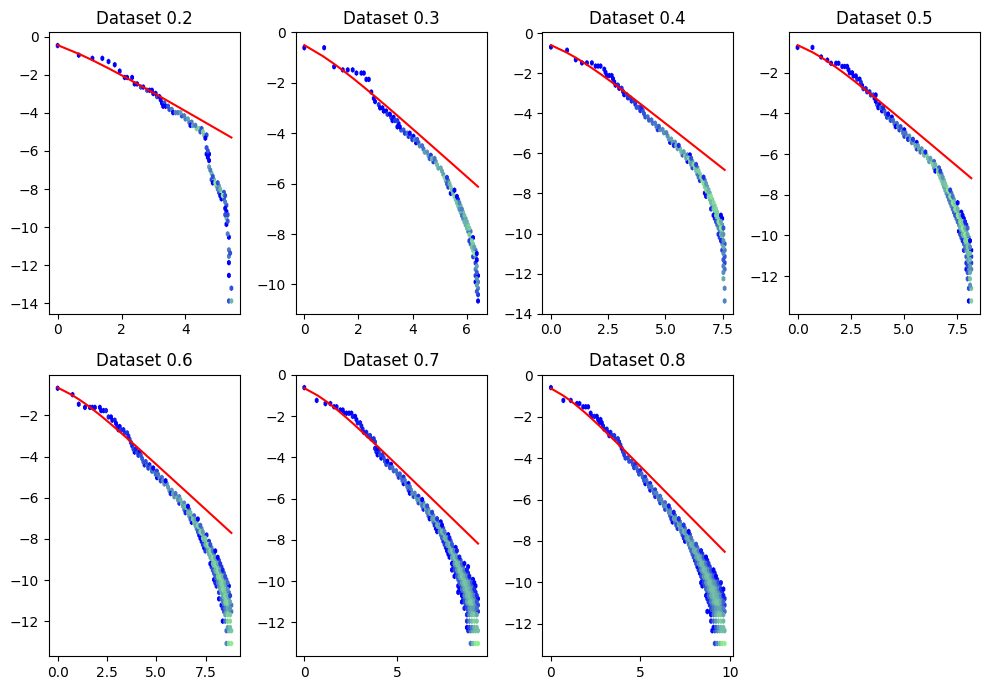

In [40]:
def plot_Zipf_curve_subplot(all_data, topks):
    # Determine the number of rows needed for subplots based on the number of datasets
    num_plots = len(all_data)
    fig, axs = plt.subplots(2, 4, figsize=(10, 7))
    axs = axs.flatten()  # Flatten the axs array for easy indexing
    
    for idx, data in enumerate(all_data):
        x_values, y_values, fitted_line, _ = Zipf_curve(data)
        colors = ["blue", "lightgreen"]
        cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)
        
        ax = axs[idx]
        # Plotting on the subplot
        hb = ax.hexbin(np.log(x_values), np.log(y_values), gridsize=70, cmap=cmap, bins='log')
        ax.plot(np.log(x_values), np.log(fitted_line), color='red')
        ax.set_title(f"Dataset {topks[idx]}")
        
    # Hide any unused subplots if the number of datasets is odd
    if num_plots % 2 != 0:
        axs[-1].axis('off')

    plt.tight_layout()
    plt.show()

plot_Zipf_curve_subplot(all_data, ['0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8'])  # assuming all_data is your list of datasets